<!-- DON'T EDIT THIS CELL! -->
<!-- TYPE SHIFT+ENTER AND GO TO THE NEXT CELL -->

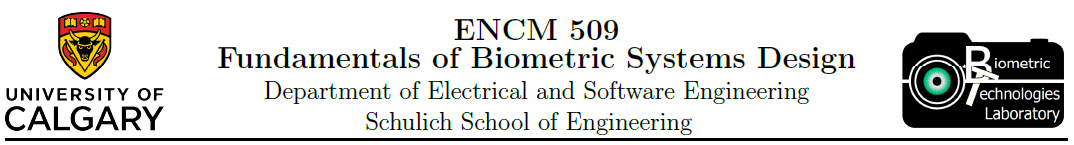

<center>
    <h1>Laboratory Experiment #3</h1>
    <h2>Biometric-based verification: Signature</h2>
    <h2>Name: Talha Khalil Id: 30037871</h2>
</center>

## Introduction
The purpose of this lab is to learn how to handle and compare biometric data using gaussian mixtures, from which in this case conclusions can be made about validity of a signature.

## Exercises

**General Marks**
1. Introduction (a paragraph about the purpose of the lab).
2. (10 marks) Description of the result on each exercise  with illustrations/graphs and analysis of the results (marks are distributed as shown in the Exercise section).
3. Conclusion (a paragraph on what is the main take-out of the lab).

**Specific Questions**

A detailed description of each exercise to be included in your report (10 marks total) is given below:

In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
import pandas as pd
from sklearn.mixture import GaussianMixture
from scipy.stats import norm

Loading Signatures

In [2]:
# Structure of data folder:
# 'signature_samples/Talha_Signatures/'
# 'signature_samples/Shelby_Signatures/'
# 'signature_samples/Shelby_Forging_Talha/'

dir_authentic = 'signature_samples/Talha_Signatures/'
dir_impostor = 'signature_samples/Shelby_Forging_Talha/'
dir_other_word = 'signature_samples/Shelby_Signatures/'
# amount of signatures to be loaded
total_signatures = 30

# lists to store the loaded signatures
authentic_signatures_list = []
impostor_signatures_list = []
other_word_signatures_list = []

# loading 'total_signatures' signatures from both "authentic" and "impostor" 
for i in range(total_signatures):
    # columns: [X, Y, Pressure, Time]
    csv_auth = pd.read_csv(dir_authentic + 'T%d.csv' % (i))
    csv_imp = pd.read_csv(dir_impostor + 'ST%d.csv' % (i))
    csv_other = pd.read_csv(dir_other_word + 'S%d.csv' % (i))

    authentic_signatures_list.append(csv_auth.values)
    impostor_signatures_list.append(csv_imp.values)
    other_word_signatures_list.append(csv_other.values)    

print('Size of the "Authentic Signatures" list: %d' % (len(authentic_signatures_list)))
print('Size of the "Impostor Signatures" list: %d' % (len(impostor_signatures_list)))
print('Size of the "Other Word Signatures" list: %d' % (len(other_word_signatures_list)))

Size of the "Authentic Signatures" list: 30
Size of the "Impostor Signatures" list: 30
Size of the "Other Word Signatures" list: 30


#### Defining Function

In [3]:
def plot_gaussian_mixture_model_scores(training_patterns : int, training_components: int, 
                                       authentic_list: list, impostor_list: list, second_item_legend):
    # number of signature samples to use for training the models
    NUMTRAININGPATTERNS = training_patterns

    # number of Gaussian mixture components in the GMM
    NUMGCOMPONENTS = training_components

    # usually we don't know the final size of train_set because
    # each signature has different number of points. 
    # to later on use 'concatenate', is necessary to take the first sample outside the loop
    train_set = np.reshape(authentic_list[0], (-1,4))

    # this for-loop put all the first "NUMTRAININGPATTERNS" in a huge matrix
    # this matrix, stored in the varaible "train_set" will be used for the training
    for i in range(1,NUMTRAININGPATTERNS):
        # taking from authentic/genuine
        sample = np.reshape(authentic_list[i], (-1,4))
        train_set = np.concatenate((train_set, sample), axis=0)
    
    # Training the GaussianMixture model from Scikit-Learn library
    # the .fit(...) will perform the training step using the "train_set" 
    gmm = GaussianMixture(n_components=NUMGCOMPONENTS).fit(train_set)
        # to store all the scores calculated
    
    authentic_scores = []
    # going through the remaining signatures after removing the first training_patterns for training
    for i in range(NUMTRAININGPATTERNS, total_signatures):
        # taking from authentic/genuine
        sample =  np.reshape(authentic_list[i], (-1,4))
        # compute the per-sample average log-likelihood of the given data.
        score = gmm.score(sample)
        # add the score calculated to the list aScores
        authentic_scores.append(score)
        
    forged_scores = []
    for i in range(total_signatures):
        # taking from the impostor
        sample =  np.reshape(impostor_list[i], (-1,4))
        score = gmm.score(sample)
        forged_scores.append(score)
        
    # authentic set
    authentic_Mu = np.mean(authentic_scores)
    authentic_Std = np.std(authentic_scores)

    # impostor set
    impostor_Mu = np.mean(forged_scores)
    impostor_Std = np.std(forged_scores)

    print('Mean of Authentic Scores: %.4f' % (authentic_Mu), ' STD of Authentic Scores: %.4f' % (authentic_Std))
    print('Mean of Impostor Scores: %.4f' % (impostor_Mu), ' STD of Impostor Scores: %.4f' % (impostor_Std))
    
    # change this range for your set
    lower_bound = min(min(forged_scores), min(authentic_scores))
    lower_bound = impostor_Mu-impostor_Std*5

    x = np.arange(lower_bound, 0, 0.01)

    authentic_prob = norm.pdf(x, loc=authentic_Mu, scale=authentic_Std)
    impostor_Prob = norm.pdf(x, loc=impostor_Mu, scale=impostor_Std)
    plt.figure(figsize=(20,5))
    plt.subplot(1,3,1)
    plt.plot(x, authentic_prob, 'b')
    plt.plot(authentic_scores, np.zeros(len(authentic_scores)), 'bs', lw=2, label='Authentic')
    plt.plot(x, impostor_Prob, 'r')
    plt.plot(forged_scores, np.zeros(len(forged_scores)), 'r^', lw=2, label=second_item_legend)
    plt.legend();
    plt.title('Training set: {} - Gaussian components: {}'.format(NUMTRAININGPATTERNS, NUMGCOMPONENTS));
    
    # Authentic set
    lower_bound = authentic_Mu-authentic_Std*4
    upper_bound = authentic_Mu+authentic_Std*4
    
    x = np.arange(lower_bound, upper_bound, 0.01)
    authentic_prob = norm.pdf(x, loc=authentic_Mu, scale=authentic_Std)

    plt.subplot(1,3,2)
    plt.plot(x, authentic_prob, 'b')
    plt.plot(authentic_scores, np.zeros(len(authentic_scores)), 'bs', lw=2, label='Authentic')
    plt.legend();
    plt.title('Training set: {} - Gaussian components: {}'.format(NUMTRAININGPATTERNS, NUMGCOMPONENTS));

    # Forged (impostor) set
    lower_bound = impostor_Mu-impostor_Std*4
    upper_bound = impostor_Mu+impostor_Std*4
    
    x = np.arange(lower_bound, upper_bound, 0.01)
    impostor_Prob = norm.pdf(x, loc=impostor_Mu, scale=impostor_Std)

    plt.subplot(1,3,3)
    plt.plot(x, impostor_Prob, 'r')
    plt.plot(forged_scores, np.zeros(len(forged_scores)), 'r^', lw=2, label=second_item_legend)
    plt.legend();
    plt.title('Training set: {} - Gaussian components: {}'.format(NUMTRAININGPATTERNS, NUMGCOMPONENTS));

- **Exercise 1** (4 marks): Create  your own data (three sets of signatures recorded as `.csv` files), or the data provided on D2L. Use the sample Notebook file `Lab3-SigVerif GMM.ipynb`  to classify set 1 (genuine) and set 2 (impostor). Follow the instructions described in  Section 2.2 and repeat this process for 2 different set of parameters (the number of signatures used for training, and the number of Gaussian mixture components, for example 20, 30, 40, ...), total 4 different pairs. In your report, include the illustrations of the distributions for these 4 sets of parameters. Include the 4 sets of distribution plots (figures) for your report. Include a brief analysis of how varying the above parameters influence  the classification results.
		
	 Plot the matching scores' PDFs of the *authentic* (genuine) and *forged* (impostor) sets. Find  the mean ($\mu$) and standard deviation ($\sigma$) for the genuine and impostor scores (variables `aMu`, `fMu`, and `aStd`, `fStd`, respectively). Use two other different sets of parameters, see the difference of plotting the pair of curves (authentic and impostor) together and separately. 

#### Original Set of Parameters
20 training sets, 20 Gaussian mixture model components

Mean of Authentic Scores: -16.9058  STD of Authentic Scores: 1.2451
Mean of Impostor Scores: -35.1807  STD of Impostor Scores: 11.2938


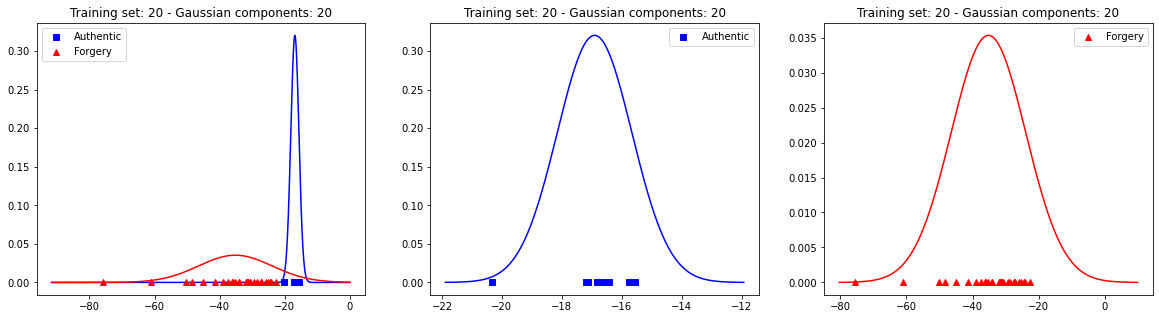

In [4]:
plot_gaussian_mixture_model_scores(20,20,authentic_signatures_list, impostor_signatures_list, 'Forgery')

#### First Set of Parameters, increasing gaussian components
20 training sets, 30 Gaussian mixture model components

Mean of Authentic Scores: -17.5886  STD of Authentic Scores: 1.6847
Mean of Impostor Scores: -39.4389  STD of Impostor Scores: 15.4760


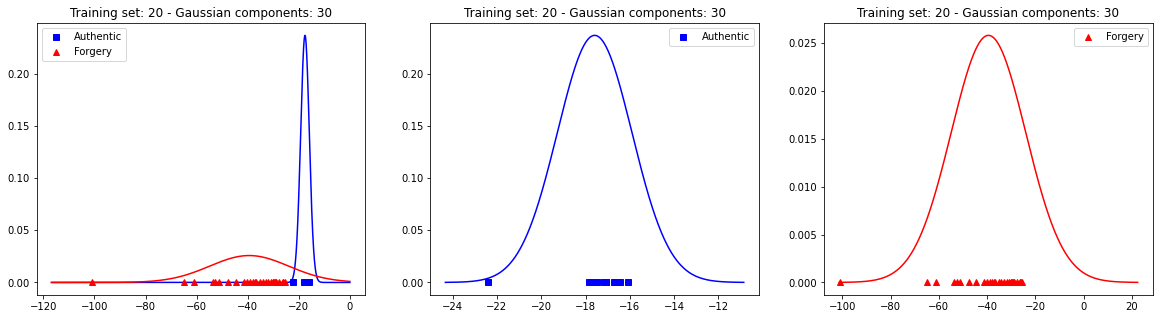

In [5]:
plot_gaussian_mixture_model_scores(20,30,authentic_signatures_list, impostor_signatures_list, 'Forgery')

#### Second Set of Parameters, decreasing gaussian components
20 training sets, 10 Gaussian mixture model components

Mean of Authentic Scores: -16.4574  STD of Authentic Scores: 0.9106
Mean of Impostor Scores: -29.2165  STD of Impostor Scores: 8.0782


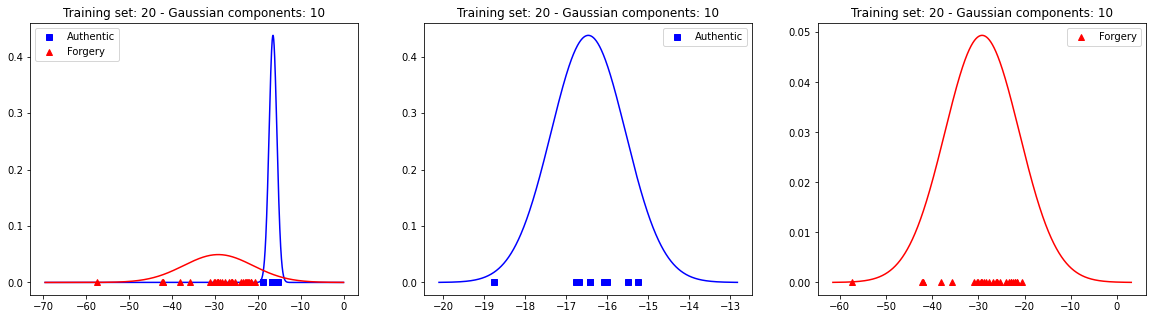

In [6]:
plot_gaussian_mixture_model_scores(20,10,authentic_signatures_list, impostor_signatures_list, 'Forgery')

#### Third Set of Parameters, increasing training set
25 training sets, 20 Gaussian mixture model components

Mean of Authentic Scores: -16.9959  STD of Authentic Scores: 1.6637
Mean of Impostor Scores: -33.9562  STD of Impostor Scores: 11.9937


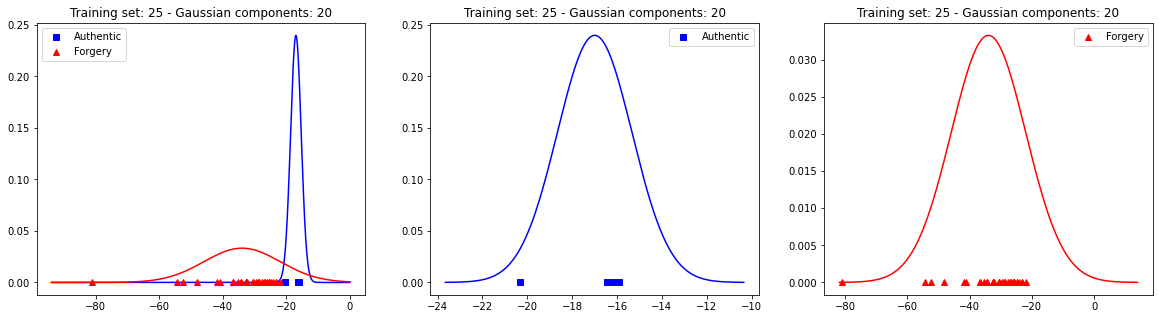

In [7]:
plot_gaussian_mixture_model_scores(25,20,authentic_signatures_list, impostor_signatures_list, 'Forgery')

#### Fourth Set of Parameters, decreasing training set
10 training sets, 20 Gaussian mixture model components

Mean of Authentic Scores: -18.2576  STD of Authentic Scores: 2.1457
Mean of Impostor Scores: -38.7962  STD of Impostor Scores: 14.2514


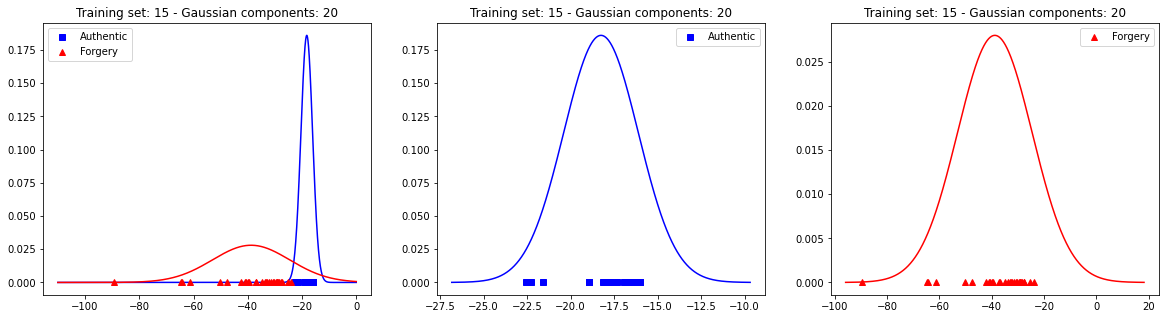

In [8]:
plot_gaussian_mixture_model_scores(15,20,authentic_signatures_list, impostor_signatures_list, 'Forgery')

#### Conclusion
When comparing set 1 and 2  to the original set we can conclude that when we increase the number of components for the gaussian mixture model the standard deviation also increases. And when comparing set 3 and 4 to the original set we can conclude that decreasing the training set amount more greatly changes the standard deviation than increasing does, however, one thing to note is that even increasing the training set amount can increase the standard deviation. 

- **Exercise 2** (4 marks): Consider the genuine set and the second set of impostor signatures that are very different (in shape, length, i.e. a different writing or another person signature). 
	Repeat the process as described  in Exercise 1,  for 2 different set of parameters (the number of signatures used for training, and the number of Gaussian mixture components, for example 20, 30, 40, ...), total 4 different pairs. In your report, include the illustrations of the distributions for these 4 sets of parameters. 
	Plot the matching scores' PDFs of the *authentic*  (genuine) and *impostor* sets. Find  the mean ($\mu$) and standard deviation ($\sigma$) for the genuine and impostor scores (variables `aMu`, `fMu`, and `aStd`, `fStd`, respectively). Compare these results against the results of Exercise 1.

#### Original Set of Parameters
20 training sets, 20 Gaussian mixture model components

Mean of Authentic Scores: -16.9124  STD of Authentic Scores: 1.4523
Mean of Impostor Scores: -758.7429  STD of Impostor Scores: 115.5971


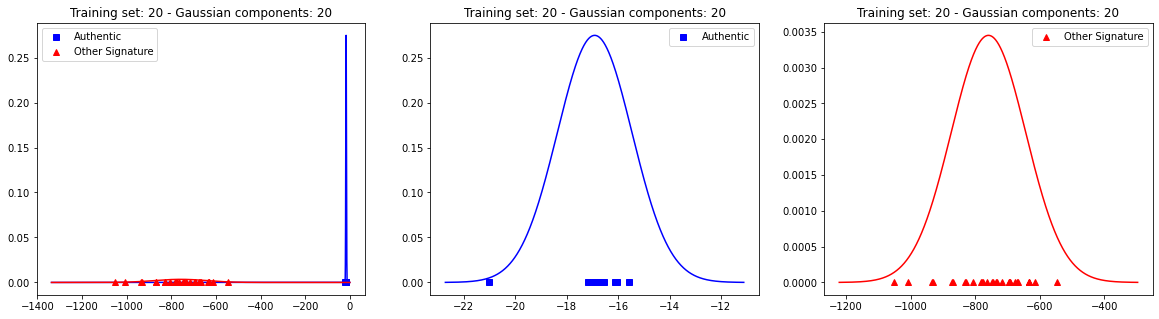

In [9]:
plot_gaussian_mixture_model_scores(20,20,authentic_signatures_list, other_word_signatures_list, 'Other Signature')

#### First Set of Parameters, increasing Gaussian mixture model components
20 training sets, 30 Gaussian mixture model components

Mean of Authentic Scores: -17.9026  STD of Authentic Scores: 1.4117
Mean of Impostor Scores: -956.6936  STD of Impostor Scores: 143.7335


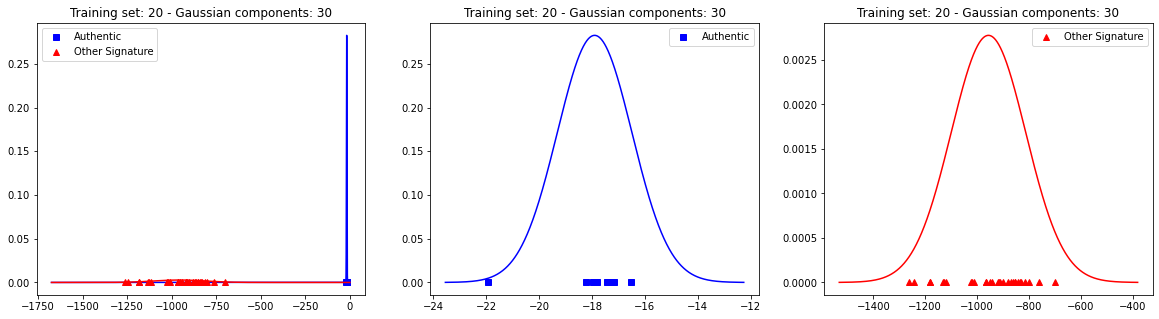

In [10]:
plot_gaussian_mixture_model_scores(20,30,authentic_signatures_list, other_word_signatures_list, 'Other Signature')

#### Second Set of Parameters, decreasing Gaussian mixture model components
20 training sets, 10 Gaussian mixture model components

Mean of Authentic Scores: -16.3178  STD of Authentic Scores: 0.9466
Mean of Impostor Scores: -270.4821  STD of Impostor Scores: 35.0260


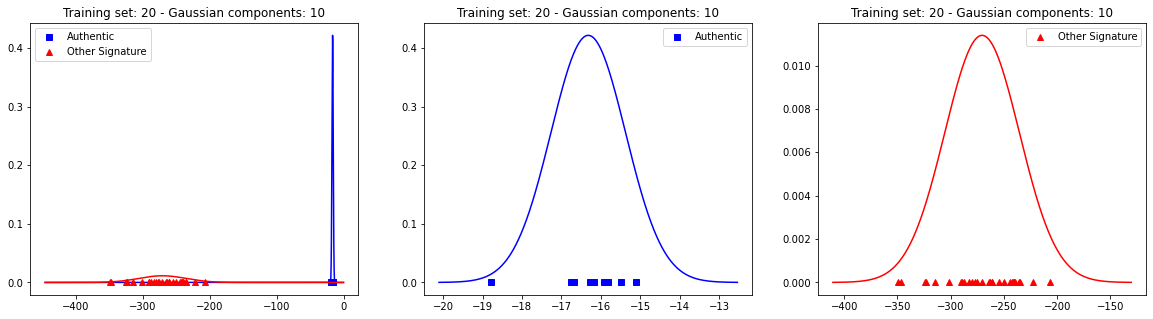

In [11]:
plot_gaussian_mixture_model_scores(20,10,authentic_signatures_list, other_word_signatures_list, 'Other Signature')

#### Third Set of Parameters, increasing training set
25 training sets, 20 Gaussian mixture model components

Mean of Authentic Scores: -16.9613  STD of Authentic Scores: 1.7207
Mean of Impostor Scores: -416.8561  STD of Impostor Scores: 58.4910


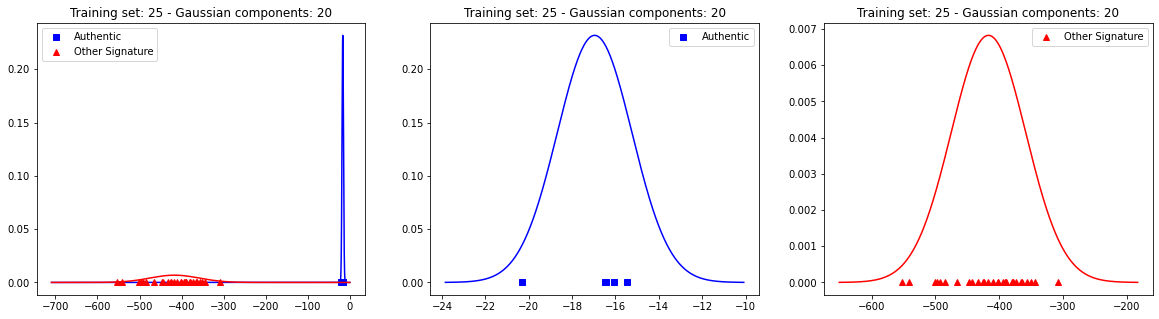

In [12]:
plot_gaussian_mixture_model_scores(25,20,authentic_signatures_list, other_word_signatures_list, 'Other Signature')

#### Third Set of Parameters, decreasing training set
15 training sets, 20 Gaussian mixture model components

Mean of Authentic Scores: -18.0335  STD of Authentic Scores: 2.1929
Mean of Impostor Scores: -443.0487  STD of Impostor Scores: 53.0311


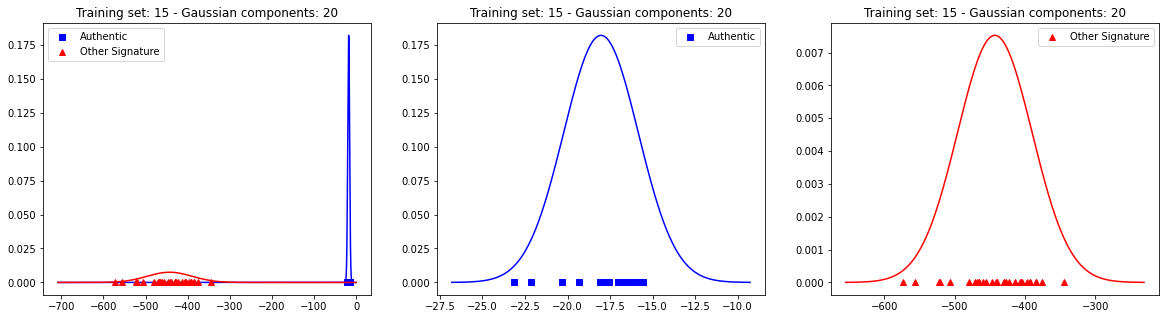

In [13]:
plot_gaussian_mixture_model_scores(15,20,authentic_signatures_list, other_word_signatures_list, 'Other Signature')

#### Conclusion
Similarly to exercise 2 we see the same behaviour, where set 1 and 2 showcase that increasing the number of components for the gaussian mixture model increases the standard deviation. We also observe that there is a 'sweet spot' for the amount of training data used compared to testing data, where the standard deviation increases more so when decreasing the training set amount, but the standard deviation still does increase when increasing the amount of training data as well but not as much.

When comparing the results specfically from exercise 1 and 2, looking at the plots we can clearly see the distinction between the two words in exercise 2. Where as in exercise 1 we do see an overlap as the over all shape of the two, genuine and forgery are similar. This makes sense as the forgery having a similar shape to the training set would influence the scores more. An interesting test to fruther expand on this would be to have the authentic author also replicate the 'other signature' and see how that fairs in scoring showcasing if the handwriting it self also has an influence as greatly as the shape of the text.

- **Exercise 3** (2 marks): Consider your plots from Exercise 1 or 2. Formulate a hypothesis $H_0$ about the $\mu$ and $\sigma$ of the entire population of the authentic signatures, and analytically test this hypothesis based on your sample (your 10 or more signatures) given the level of the test significance equal to 0.05 ($\alpha=0.05$, level of confidence: $1-\alpha= 0.95$). Now, change the critical values (choose reasonable values) and evaluate the FRR value.  Evaluate your FRR and FAR. You can do the calculations manually, and include in  your report using the Markdown or taking a photo and adding this photo to the notebook (see Lab 1 on Markdown). 

Using the entire authentic population we can recalculate the mean and standard deviation.

In [18]:
train_set = np.reshape(authentic_signatures_list[0], (-1,4))

for i in range(1,20):
    sample = np.reshape(authentic_signatures_list[i], (-1,4))
    train_set = np.concatenate((train_set, sample), axis=0)

# Training the GaussianMixture model from Scikit-Learn library
# the .fit(...) will perform the training step using the "train_set" 
gmm = GaussianMixture(n_components=20).fit(train_set)
    # to store all the scores calculated

authentic_scores = []

# going through the remaining signatures after removing the first training_patterns for training
for i in range(20, total_signatures):
    # taking from authentic/genuine
    sample =  np.reshape(authentic_signatures_list[i], (-1,4))
    # compute the per-sample average log-likelihood of the given data.
    score = gmm.score(sample)
    authentic_scores.append(score)
    #print(score)

# authentic set
authentic_Mu = np.mean(authentic_scores)
authentic_Std = np.std(authentic_scores)
#print('Mean of Authentic Scores: %.4f' % (authentic_Mu), ' STD of Authentic Scores: %.4f' % (authentic_Std))


*Since the gaussian mixture is non-deterministic, this was run once and the values were noted.*

Values noted:

-15.490896360582106

-16.820769849424437

-16.76880295146936

-16.126968833008863

-16.495060758722506

-17.020045180358782

-16.388572477863253

-20.24369435639435

-17.18282328273706

-16.028148636272135

Mean of Authentic Scores: -16.8566  STD of Authentic Scores: 1.2267

$\mu$ of the genuine score -16.8566  is and the $\sigma$ is 1.2267. Since we have an $\alpha$ of 0.05 we obtain a z value of $z_{0.05/2}=1.96$. Now we estimate the interval of the population mean using the following formula: 

$\overline{x}-z_{\alpha/2} \frac{\sigma}{\sqrt{n}} < \mu < \overline{x}+z_{\alpha/2} \frac{\sigma}{\sqrt{n}}$

Where we obtain:
$-16.8566 - 1.96\frac{1.2267}{\sqrt{10}} < \mu < -16.8566  + 1.96\frac{1.2267}{\sqrt{10}}$

Critical region: $-17.6169 < \mu < -16.0963$

From which we can formulate a hypothesis $H_{0}: \mu=-16.84, \sigma=1.2$
From which we can get an FRR of $ 2/10 = 0.2$, because 2 scores fall out of the region

We can instead change the critical values to be: $-17.6< \mu < -16.0$
From which we can calculate the new z values using the forumla

$z_1 = \frac{\overline{x_1}-\mu}{\frac{\sigma}{\sqrt{n}}}$
$z_2 = \frac{\overline{x_2}-\mu}{\frac{\sigma}{\sqrt{n}}}$

$z_1 = \frac{-17.6-(-16.84)}{\frac{1.2}{\sqrt{10}}}$
$z_2 = \frac{-16.0-(-16.84)}{\frac{1.2}{\sqrt{10}}}$

$z_1 = -2.0028$
$z_2 = 2.2136$

$FRR = P(z<-2.0028) + P(z>2.2136) = 0.0228 + (1-0.9864) = 0.0364$

Mean of Impostor Scores: -35.1807  STD of Impostor Scores: 11.2938 for forged signtures. Note since the guassian mixture isn't deterministic these values were from one of the previous runs.

From these we can determine $H_1$

$z_1 = \frac{-17.6+35.1807)}{\frac{11.2938}{\sqrt{30}}}$
$z_2 = \frac{-16.0+35.1807)}{\frac{11.2938}{\sqrt{30}}}$

$z_1 = 8.5262$
$z_2 = 9.3021$

$FAR = 0$

#### Conclusion
The hypothesis with the mean of 16.84 and standard deviation of 1.2 is good, as it has a FRR of 3.6 % and a FAR of 0%.

## Lab Conclusion
Using gausian mixtures to compare the validity of signatures can be a good method. As shown through out the lab with the various distinctions between the impostor and genuine signatures, there seems to be little overlap between the two PDFs, and none when comparing the 'other_word' set. From this labs results we can also conclude that decreasing the components of the gaussian mixture can decrease the standard deviation.